$${\bf Name}:\text{  Mainak Biswas}$$

$$ \text {IISc, PhD student, PMRF Lecture (Assignment 4 - solutions)} $$

In [65]:
# importing relevant packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches

In [3]:
from sklearn.datasets import fetch_openml
X_mnist, y_mnist = fetch_openml("mnist_784",version=1,return_X_y=True,as_frame=False)
#make the data into usable form
y_mnist = y_mnist.astype('int')
X_mnist = X_mnist/255.0

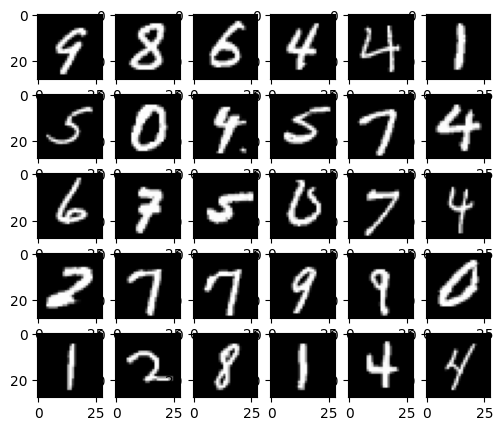

In [4]:
def display_grid(list_conn, num_col):
    num_row = int(list_conn.shape[0]/num_col)
    
    fig, axes = plt.subplots(num_row, num_col, figsize=(num_col,num_row))
    for i in range(num_col*num_row):
        #ax.set_title("Conn. matrix (log scale), S = "+str(i+1), fontsize=12)
        ax = axes[i%num_row, int(i/num_row)]
        full_im = ax.imshow(list_conn[i].reshape((28,28)), cmap='gray')
    
    #make room for the colourbar on the right and plot it
    fig.subplots_adjust(right=0.88)
    plt.show()

display_grid(X_mnist[np.random.choice(np.arange(X_mnist.shape[0]), 30)], 6)

In [9]:
def get_sub_sample_10k(X, y, n_perclass=1000):
    np.random.seed(24)   #so that the same split is obtained always
    list_10k = [] 
    for label in np.unique(y):
        indices = np.where(y==label)[0]
        np.random.shuffle(indices)
        list_10k += list(indices[0:1000]) 
    return X[list_10k], y[list_10k]
X_10k, y_10k = get_sub_sample_10k(X_mnist, y_mnist)

In [13]:
print(X_10k.shape, y_10k.shape)

(10000, 784) (10000,)


# Principal Component Analysis

In [46]:
def PCA(X, nc=2):
    #calculate the covariance of data
    X = X.T # want data to be 784xN
    mu = np.mean(X, axis=1, keepdims=True)
    S = (X - mu) @ (X - mu).T

    #get the top 2 eigen values and vectors
    evals, evecs = np.linalg.eig(S)
    #all evals and evecs will be non-negative and real as S is psd
    evals = np.real(evals)
    pos_largest_evals = np.argsort(-1*evals)[0:nc]

    U = np.real(evecs[:, pos_largest_evals])
    Z = U.T @ X
    
    print("Original Dimension: {}, Reduced Dimension: {}".format(X.shape, Z.shape))
    return Z

In [47]:
Z_10k = PCA(X_10k)

Original Dimension: (784, 10000), Reduced Dimension: (2, 10000)


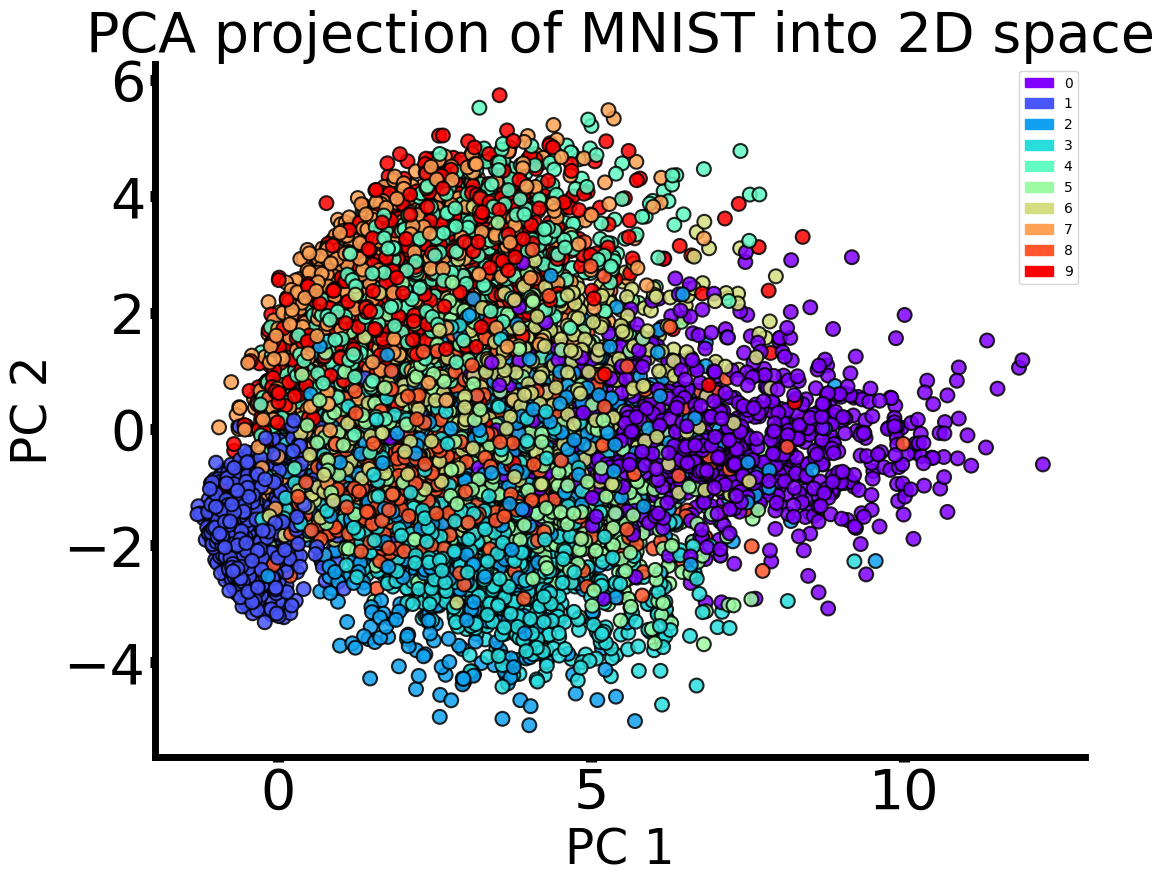

In [97]:
def plot_scatter_classwise(Z, y, xlab='PC 1', ylab='PC 2', title_="PCA projection of MNIST into 2D space", addon=""):
    #for every label plot the scatter plot
    fig, ax = plt.subplots(figsize=(12, 9))
    mn_x, mx_x = np.min(Z[0, :]), np.max(Z[0, :])
    mn_y, mx_y = np.min(Z[1, :]), np.max(Z[1, :])
    plt.xlabel(xlab, fontsize=35)
    plt.ylabel(ylab, fontsize=35)
    plt.title(title_, fontsize=40)
    
    rng = (mx_x - mn_x)
    mn_x = mn_x - 0.05*rng
    mx_x = mx_x + 0.05*rng
        
    rng = (mx_y - mn_y)
    mn_y = mn_y - 0.05*rng
    mx_y = mx_y + 0.05*rng
    plt.xlim([mn_x, mx_x])
    plt.ylim([mn_y, mx_y])

    plt.rc('xtick', labelsize=40)
    plt.rc('ytick', labelsize=40)
    colours = cm.rainbow(np.linspace(0, 1, np.unique(y).shape[0]))
        
    x_r = []
    y_r = []
    c_r = []
    for i in range(y.shape[0]):
        x_r.append(Z[0, i])
        y_r.append(Z[1, i])
        c_r.append(colours[y[i]])
        
        #print(Z_i.shape)
    np.random.seed(24)
    x_r, y_r, c_r = np.array(x_r), np.array(y_r), np.array(c_r)
    perm = np.random.permutation(len(x_r))
    x_r = x_r[perm]
    y_r = y_r[perm]
    c_r = c_r[perm]
        
    plt.scatter(x_r, y_r, color=c_r, alpha=0.85, s=100, edgecolor='black', linewidth=1.5)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.tick_params(width=8)

    patches = []
    for i in np.unique(y):
        patches.append(mpatches.Patch(color=colours[i], label=addon+str(i)))
    
    plt.legend(handles=patches)


plot_scatter_classwise(Z_10k, y_10k)

**This does bring same digits to a similar space in 2D - clusters them!**

# K-means Clustering

In [94]:
class K_means:
    def __init__(self, X, k):
        # now X is in the shape [d, N]
        self.X = X
        self.k = k
        self.mus = self.initialize()
        #print(np.min(self.mus, axis=1), np.max(self.mus, axis=1))
    
    def initialize(self):
        np.random.seed(99)
        dim1_coord = np.random.uniform(low=np.min(self.X[0, :]), high=np.max(self.X[0, :]), size=(1, self.k))
        dim2_coord = np.random.uniform(low=np.min(self.X[1, :]), high=np.max(self.X[1, :]), size=(1, self.k))
        return np.append(dim1_coord, dim2_coord, axis=0)
    
    def expectation(self):
        #return distance of the form (num_centroids, Num examples)
        distance_matrix = np.zeros(shape=(self.k, self.X.shape[1]))
        for i in range(self.X.shape[1]):
            for j in range(self.k):
                #taking the l2 norm, the i, j th position store the distance of the ith point from the jth cluster (i --> d1, .. dk)
                distance_matrix[j, i] = np.linalg.norm(self.X[:, i] - self.mus[:, j], ord=2)
        return distance_matrix
    
    def maximization(self, clabel):
        #repositioning of centroids
        for j in range(self.k):
            #returns the points labeled as cluster j
            idx = np.where(clabel.squeeze() == j)[0]
            #take their mean, collapse across rows (i.e., examples)
            if len(idx) != 0:
                #coordinate of the centroids according to the redistribution
                self.mus[:, j] = np.mean(self.X[:, idx], axis = 1)

    def perform_clustering(self, max_iter=100):
        
        for i in range(max_iter + 1):
            distance_matrix = self.expectation()
            #get the label of the nearest centroid
            clabel = np.argmin(distance_matrix, axis=0, keepdims=True)
            if i < max_iter:
                self.maximization(clabel)
        return clabel

In [95]:
k_means_obj = K_means(Z_10k, 10)

In [99]:
cluster_labels = k_means_obj.perform_clustering()

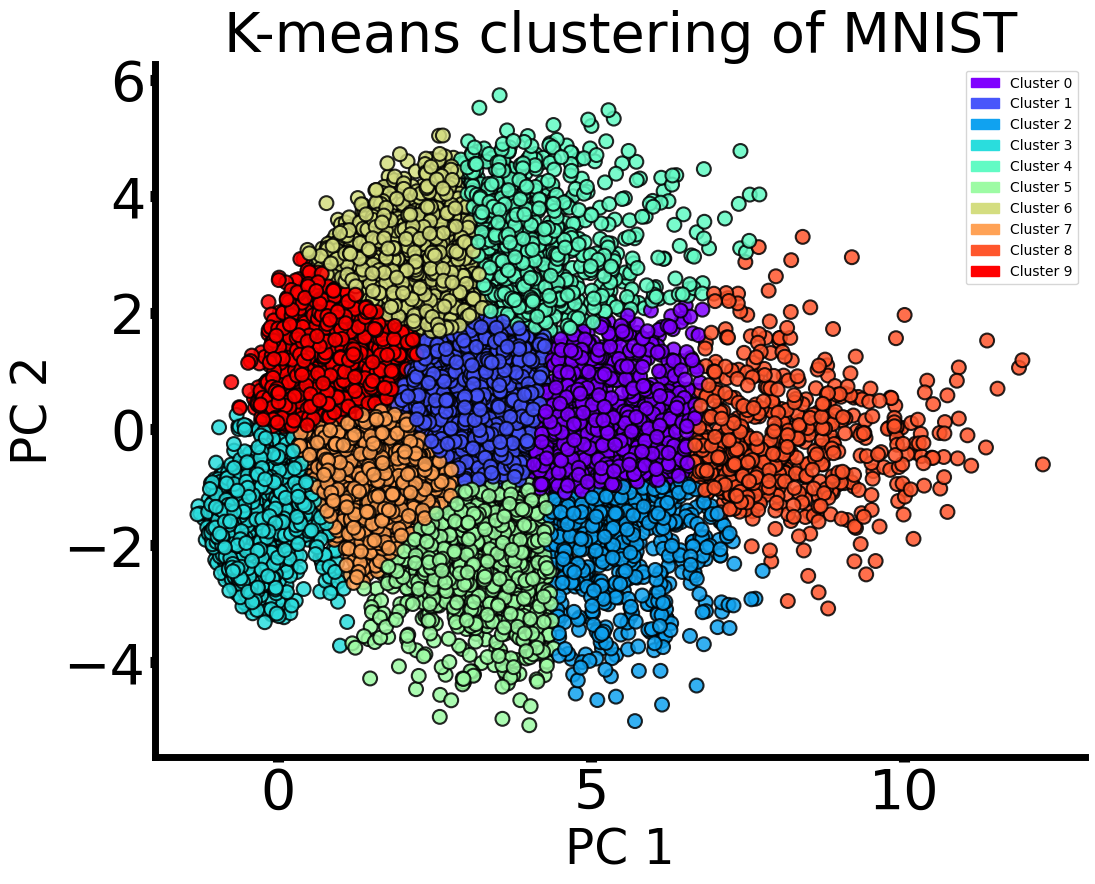

In [101]:
plot_scatter_classwise(Z_10k, np.squeeze(cluster_labels), xlab='PC 1', ylab='PC 2', title_="K-means clustering of MNIST", addon="Cluster ")

**Clustering done perfectly - since it is on the PC space the digits which were well separated on the PC space is also well-clustered.**